<a href="https://colab.research.google.com/github/Handrum/ML_Equipo_6/blob/main/TC4033_Activity1b_ID__Equipo_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>
![evidencia3](https://i.imgur.com/mu6ZuGT.jpg)

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Advance Machine Learning Methods**
* ### **Maestro Titular**: José Antonio Cantoral Ceballos
* **Tutor: Ana Bricia Galindo**

## **Actividad 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset**

*   --> Rafael Alexis Pinto Flórez | A01794500
*   --> Julio Baltazar Colín | A01794476
*   --> José Santiago Rueda Antonio | A01794118
*   --> Helmy Andrea Moreno Navarro | A01793918

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- **Objective***

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- **Instructions**

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    **Load and Preprocess Data**: You are provided a starter code to load the data. Be sure to understand the code.

    **Review MNIST Notebook (Optional)**: Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    **Start Fresh**: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    **Implement Forward and Backward Pass**: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    **Analyze and Document**: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- **Evaluation Criteria**

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- **Submission**

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


### Importación de librerias para realizar el ejercicio y que matploid grafique en el mismo archivo

In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import urllib.request
import requests
from io import StringIO, BytesIO, TextIOWrapper
from zipfile import ZipFile

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


### Se descargan los datos de un drive porque ahí lo subimos al igual que desarrollamos los siguientes pasos:


1.   Descromprimimos el archivo de mnist
2.   Convertimos los datos a Texto
3.   pasamos los datos a formato pandas CSV



In [2]:
# Define the base URL of the raw zip files
zip_link  ='https://drive.usercontent.google.com/download?id=1mbYrnaCWEaCAC-7tSlWCx2xhUIzkvvAG&export=download&authuser=0&confirm=t&uuid=16705fd0-33cb-4ac2-8432-0ad96b5afe51&at=APZUnTUW2xc_hmtGD5tXxb-by_Gv:1695432904814'

# Load the training and validation data
response = requests.get(zip_link)
zipfile = ZipFile(BytesIO(response.content))
data = TextIOWrapper(zipfile.open('asl_data/sign_mnist_train.csv'), encoding='utf-8')
train_df = pd.read_csv(StringIO(data.read()))
data = TextIOWrapper(zipfile.open('asl_data/sign_mnist_valid.csv'), encoding='utf-8')
valid_df = pd.read_csv(StringIO(data.read()))




### Imprimimos el dataframe y podemos observar lo siguiente:
***784*** pixeles y tenemos la etiqueta. La imagén se compone de 28x28

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
#El dataframe de entrenamiento toma el index, sin embargo se trabajará con los 784 vectores
train_df.shape

(27455, 785)

In [5]:
#El dataframe de validación toma el index, sin embargo se trabajará con los 784 vectores
valid_df.shape

(7172, 785)

## **Importar Images**

### Se define  la **y** de entrenamiento y la **y** de validación

In [6]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

### Función para generar un un split de los datos que regresa entradas de validación/test y salida de validación/test

In [7]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    if shuffle:
        # randomize the indexes
        indexes = np.arange(len(x))
        np.random.shuffle(indexes)
        x = x[indexes]
        y = y[indexes]

    # Calculate the split index
    split_index = int(len(x) * pct)

    # Split the data into validation and test sets
    x_val = x[:split_index]
    y_val = y[:split_index]
    x_test = x[split_index:]
    y_test = y[split_index:]

    return x_val, y_val, x_test, y_test

In [8]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

### Se remueve la **j** y la **z** ya que no se encuentran en los set de datos de mnist

In [9]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### **Normalise**

#### Función para normalizar la imagén al igual que los datos

In [10]:
def normalize_image(image_data):
    #normalize the pixel colors
    normalized_image = (image_data - image_data.min()) / (image_data.max() - image_data.min())
    return image_data

In [11]:
def normalise(x_mean, x_std, x_data):
    #normalize the data.
    return (x_data - x_mean) / x_std

In [12]:
#cálculo del promedio y la desviación estandar de los datos.
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

### Graficar muestras

In [13]:
def Plot_Image(image):
    #reshape to plot the image sqr(784) = 28 pixel imgs
    image = np.reshape(image, (28, 28))
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

#### Se muestra una imagen aleatoria y muestra el texto al que corresponde y se manda a la función plot_image

Pictures is letter: x


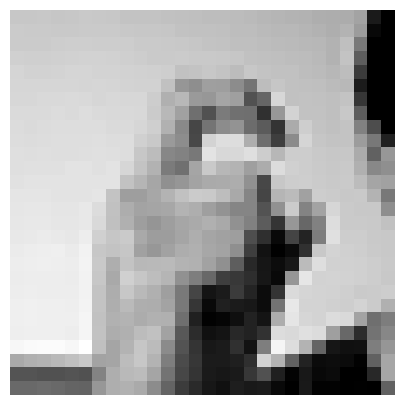

In [14]:
# Se elige un índice aleatorio del conjunto de pruebas x_test
rnd_idx = np.random.randint(len(x_test))
# Uso  del índice aleatorio para obtener una imagen específica del conjunto de pruebas
image_data = x_test[rnd_idx]
# Se normaliza la imagen con la función normalize_image definida anteriormente
image_data = normalize_image(image_data)
# Se imprime la etiqueta (ye_test) correspondiente a la imagen seleccionada utilizando el índice aleatorio.
# Se imprime como diccionario 'alphabet' que mapea los índices a letras.
print(f'Pictures is letter: {alphabet[y_test[rnd_idx]]}')
# Muestra la imagen
Plot_Image(image_data)

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

### **Mini batches**

**¿Para qué se crean los mini batch?**

***Se crean mini batch para acelerar el proceso de entrenamiento, también mejora el rendimiento del modelo y permite obtener mejor accurracy en nuestro modelo***

In [15]:
#Se divide los datos (x, y) en mini-lotes de tamaño mb_size.
def create_minibatches(mb_size, x, y, shuffle = True):
    """
    Generate minibatches of size 'mb_size' from input data 'x' and labels 'y'.

    Args:
        mb_size (int): Mini-batch size.
        x (numpy.ndarray): Input data of shape (samples, features).
        y (numpy.ndarray): Labels of shape (samples, 1).
        shuffle (bool, optional): Whether to shuffle the data. Defaults to True.

    Returns:
        generator: A generator yielding mini-batches of input data and labels.
    """

# Nos aseguramos de que el número de muestras (samples) en x sea igual al número de muestras en y
# Si no es así, nos arrojará un error con el mensaje: 'Error: Number of samples mismatch'
    assert x.shape[0] == y.shape[0], 'Error: Number of samples mismatch'

# Guardamos el número total de muestras en la variable 'total_data'
    total_data = x.shape[0]

# Se realiza un ciclo condicional
    if shuffle:

# Se debe crear una lista de índices que representan cada muestra
        idxs = np.arange(total_data)

# Los índices deben tomar una forma alterna
        np.random.shuffle(idxs)

# Se reordenan las muestras en x y y según los índices mezclados
        x = x[idxs]
        y = y[idxs]

#create the mini batches set and return them to the caller
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

##**Nuestra clase Linear, ReLU y Sequential**

![evidencia3](https://i.imgur.com/a7rr7tX.jpg[/img])

**¿Para qué nos sirven las clases Linear, ReLU y Sequencial? ¿Qué función cumplen en los modelos de aprendizaje profundo?**

Como bien el profe ha explicado en clase, esta implementación se aplica a una red neuronal simple y nos ayuda a realizar la implementación de las operaciones de **FORWARD** y **BACKWARD**.

En el caso de las Clase **linear** inicializa la función con **__init__** allí toma el tamaño inicla de las entradas y las salidas como argumentos, representando allí la cantidad de neuronas que se encuentran en la capa anterior y en la ques e encuentra (capa actual) .

En el caso de la aplicación de los pesos (**W**) crea una variable llamada **self.W** y hace uso de **Kaiming He** es muy conocida dentro del medio como una de las técnicas más acertadas que ayudan a combatir problemas de gradientes cuando se vuelven muy grandes o muy pequeños dentro de la aplicación del modelo entrenado.

**__call__**: Permite a la clase que se comporte como una función en caso de requerirla. Específicamente nos ayudará que se comporte como el **forward** de la **capa lineal**: Tomal entrada **X** y la devuelve en salida **Z**.

**self.W @ X** es una multiplicación de matrices entre las entradas y los pesos. Recordemos que para que el resultado sea condicionado a un valor se le aplica un valor b (**bias o sesgo**) o sea se realiza la sumatoria de **self.b**.

Este resultado es el que inicia el método, para aplicar posteriormente la **función de activación (a)** una función de activación NO lineal (En este caso **ReLU**).

Y finaliza con una función **backward** conocida también como **back propagation** que nos ayuda a calcular los gradientes de los parámetros de la red en función del **error**. Aquí sus argumentos son las **X** (Entradas de la capa) y **Z** (salidas de la capa).

**X.grad** nos ayuda a calcular el gradiente de la entrada, necesario para realizar el back de propagación del error a través de la red entrenada.

Parámetros como **self.W.grad** calcula el peso y **self.b.grad** calcula el sesgo. Valores que nos ayudarán en un futuro proceso para estar actualizando los valores de los pesos y de los sesgos en cada ciclo.

In [16]:
class np_tensor(np.ndarray): pass

###  **Clase Linear**

Las **Clases Linear** nos ayudan a identificar patrones en nuestro modelo y de ahí realizar las transforamciones correspondientes posteriormete.

Es interesante encontrar dentro de esta función, que inicializa una posible idea del comportamiento que tendrá nuestro modelo, sin embargo, no es suficiente, pues si continúaramos realizando el modelo con una función lineal, su resultado sería igual y nunca aprenderían de forma orgánicanuestros modelos.

Recordemos que el resultado de una función es una recta:

$$y = mx + b^1$$

In [17]:
# Se define una clase llamada 'Linear'
class Linear():

    # Se crea el método init para la clase 'Linear'
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''

# Se inicializa los pesos (W) de la capa lineal
# Se utiliza una inicialización basada en la raíz cuadrada del tamaño de entrada, que a menudo se utiliza para mejorar la convergencia durante el entrenamiento.
# Después de inicializar, se ajusta la forma del tensor (si es necesario) utilizando el método 'view'.
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)

# Se define el método __call__ para la clase, lo que permite que las instancias de la clase se llamen como funciones

    def __call__(self, X): # esta el forward de la clase lineal

        # Se realiza la operación lineal: multiplica los pesos (W) con los datos de entrada (X) y suma el sesgo (b)
        Z = self.W @ X + self.b
        return Z

# Se realiza la retropropagación para la capa lineal.
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)

### **Clase ReLU**

$$f(x) = max(0, x)$$

Conocida como **Rectified Linear Unit** convirtiendo los valores negativos a 0 y manteniendo los valores positivos sin cambios. (Tomado del video del profe)

Existen otras funciones de activación muy conocidas en el mercado, tales como **Sigmoid o Logística** haciéndola útil para temas de **clasificación binaria**. Sin embargo, ReLU sigue siendo más precisa en este procesos de Redes Profundas.

**Tanh (Tangente hiperbólica)** Ayuda con lo valores de salidas entre los rangos -1 y 1. Su resultado es más amplio que la Sigmoid.

Cuando se desee hacer uso de algunas de estas funciones es importante comprender el contexto, la naturaleza de los datos y la arquitectura de Red.

In [18]:
# La clase ReLU que nos ayudará a activar la capa en dos funciones
class ReLU():

    # __call__ es una función especial en Python que permite que las instancias de una clase se comporten como funciones.
    def __call__(self, Z):
        return np.maximum(0, Z)

    # Este método se utiliza para el paso de retropropagación (backpropagation) en redes neuronales. Calcula el gradiente de la función ReLU.
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### **Clase Sequential**

Esta clase nos ayuda a construir modelos capa por capa de forma secunecial como su nombre lo dice y se van añadiendo una tras otra. Para nuestro ejercicio es ideal, ya que se adapta al modelo con entradas y salidas tensoriales, ya que es lineal apilando cada capa sin ningún tipo de fusiones. Se encuentra en la biblioteca de Keras integrada actualmente con Tensorflow, midiendo los modelos de una forma muy sencilla.

No es un modelo que se adapte a redes con múltiples capas. Es muy práctico en su compilación, como vemos a través del código contiene funciones de pérdida y métricas que monitorean el modelo durante el entrenamiento.

Si desglosamos el código podemos ver lo siguiente:

Se inicia con un construyendo la clase **Sequential_layers()** y almacena las capas con **self.layers**, luego a través de la variable **self.x** almacenará a futuro lo valores que se ingresen de forma manual.

A través de un diccionario **self.outputs** almacenará los valores de las salidas de las capas.

Al igual que en la calse **Linear** se crea el método **__call**__** para que opere como una función también dentro del procesos. En esta ocasión el código final retorna la salidad de la última capa.

También realiza una operación de propagación hacia atrás para actualizar los datos de los gradientes de cada capa (desde la última hasta la primera).

Se actualizan los pesos y los sesgos con el método de descenso del gradiente. Recorre una a una las capas y si (Ciclo For **If**) no es del tipo ReLU, actualiza sus pesos y sesgos haciendo uso de **learning_rate**.

Finalmente mediante **predict** se retorna el valor máximo de salida (**argmax**) de numpy para clasificar el resultado.





In [19]:
# Se inicializa la instancia con una lista de layers
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''

        # Se instancia de esta clase, procesará la entrada X a través de todas las capas en self.layers de forma secuencial.
        self.layers = layers
        self.x = None
        self.outputs = {}

    # Se llama a una instancia de esta clase, procesará la entrada X a través de todas las capas en self.layers
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x

    # Se realiza el paso de retropropagación a través de la red.
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])

    #Se actualiza los pesos (W) y los sesgos (b) de cada capa en la red
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad

    # Se devuelve la predicción de clase para una entrada X
    def predict(self, X):
        return np.argmax(self.__call__(X))

### **Cost Function**

Bajo el siguiente ejercicio podemos ver los resultados de la eficacia de nuestro modelo entre la **Y Real** y nuestra **Y de predicción**. Representado gráficamente podemos verlo a través del siguiente ejemplo:

![evidencia3](https://i.imgur.com/1VuEh18.png)
$$IMG-Tomada-de-Blog-IBM$$

Esta pérdida o costo le permite al modelo ajustar los parámetros moviéndose continuamente hasta que el modelo deja de aprender. _"Vale la pena señalar que una función de pérdida se refiere al error de un ejemplo de entrenamiento, mientras que una función de costo calcula el error promedio en todo un conjunto de entrenamiento."_

In [20]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### **Loop de entrenamiento**

In [21]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [22]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')


# Evaluación de Hiperparámetros del Modelo

A continuación se detallan los hiperparámetros del modelo, incluyendo la cantidad de neuronas y capas ocultas, así como el tamaño del lote, la tasa de aprendizaje y las épocas que representan la cantidad de iteraciones. También se presentan los resultados más relevantes obtenidos durante el proceso de búsqueda de los mejores parámetros.

## Primera Combinación:

### Parámetros:

- Capas Ocultas: 1
- Cantidad de Neuronas: 100
- ReLu al final: No
- Tamaño del Lote: 1024
- Tasa de Aprendizaje: 1e-2
- Épocas: 5

### Resultados:

- Último Costo: nan
- Última Precisión: 0.046
- Precisión: 0.0459

## Segunda Combinación:

### Parámetros:

- Capas Ocultas: 1
- ReLu al final: No
- Cantidad de Neuronas: 500
- Tamaño del Lote: 128
- Tasa de Aprendizaje: 1e-4
- Épocas: 5

### Resultados:

- Último Costo: 0.0727
- Última Precisión: 0.7747
- Precisión: 0.7409

## Tercera Combinación:

### Parámetros:

- Capas Ocultas: 1
- ReLu al final: Sí
- Cantidad de Neuronas: 400
- Tamaño del Lote: 256
- Tasa de Aprendizaje: 1e-3
- Épocas: 10

### Resultados:

- Último Costo: 0.0017
- Última Precisión: 0.7944
- Precisión: 0.8064

## Cuarta Combinación:

### Parámetros:

- Capas Ocultas: 1
- ReLu al final: Sí
- Cantidad de Neuronas: 500
- Tamaño del Lote: 280
- Tasa de Aprendizaje: 1e-3
- Épocas: 10

### Resultados:

- Último Costo: 0.0022
- Última Precisión: 0.8100
- Precisión: 0.8189

## Quinta Combinación (Mejor):

### Parámetros:

- Capas Ocultas: 2
- ReLu al final: No
- Cantidad de Neuronas: 300
- Tamaño del Lote: 256
- Tasa de Aprendizaje: 1e-3
- Épocas: 10

### Resultados:

- Último Costo: 0.0006
- Última Precisión: 0.8078
- Precisión: 0.8059


In [35]:
model = Sequential_layers( [Linear(784, 300), ReLU(), Linear(300, 300), ReLU(), Linear(300, 300),  ReLU(), Linear(300, 24)] )
mb_size = 256
learning_rate = 1e-3
epochs = 10


Se genera un bloque para entrenar el modelo, ya que aveces en la primera ejecución no convergia pudiendo deberse al conjunto de datos con los cuales se entrenaba.

In [36]:
train(model, epochs, mb_size, learning_rate)

costo: 0.020951171194372675, accuracy: 0.7827663134411601
costo: 0.00829020119685202, accuracy: 0.7967094255437813
costo: 0.0026510072248836654, accuracy: 0.8025655326268823
costo: 0.0026030742682445424, accuracy: 0.7992191857222533
costo: 0.002472037167135656, accuracy: 0.8047964305633017
costo: 0.001354276213651953, accuracy: 0.8045175683212493
costo: 0.0016425308642546233, accuracy: 0.8073061907417736
costo: 0.0008615596751185042, accuracy: 0.8078639152258784
costo: 0.0010643816693339792, accuracy: 0.8103736754043502
costo: 0.0009898951545884158, accuracy: 0.8100948131622978


In [37]:
print(accuracy(x_test, y_test, mb_size))

0.809537088678193


### Test your model on Random data from your test set

Se hace la prueba con un elemento del grupo de prueba y se valida el valor predicho con el valor real

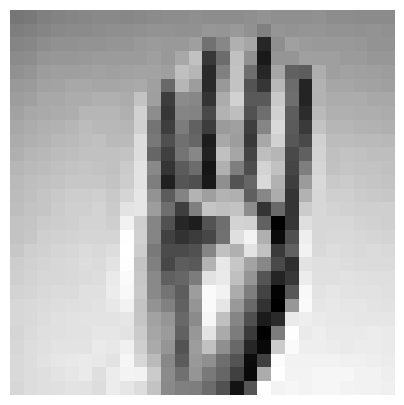

el valor predicho es: b el valor real es:b


In [26]:
idx = np.random.randint(len(y_test))
Plot_Image(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')

#**Conclusiones**

* Número de capas ocultas y cantidad de neuronas: La mejor configuración parece ser la que tiene 2 capas ocultas y 300 neuronas en cada capa. Esto sugiere que un modelo ligeramente más profundo y ancho funcionó mejor en este caso en comparación con modelos más simples.

* Función de activación: La inclusión de la función de activación ReLU al final de las capas ocultas parece haber mejorado el rendimiento del modelo en términos de precisión. Esto sugiere que la no linealidad introducida por ReLU fue beneficiosa en este caso.

* Tamaño del lote (Batch Size): Un tamaño de lote de 256 se utilizó en la configuración que produjo el mejor resultado. Para las pruebas realizadas con tamaños inferiores y superiores diferentes evidentemente daba un resultado negativo en la precisión del modelo.

* Tasa de aprendizaje (Learning Rate): Una tasa de aprendizaje de 1e-3 se utilizó en la configuración más exitosa. En la cual coincide con la sugerida por el docente ya que al utiliza una tasa más pequeña no permite que converja el modelo con una buena precisión, adicionalmente una tasa muy alta ocasiona problema con el entrenamiento y se obtienen errores en la función de costo.

* Épocas (Epochs): En general, aumentar el número de épocas de entrenamiento mejoró el rendimiento del modelo. La configuración exitosa utilizó 10 épocas, lo que permitió al modelo aprender mejor y mejorar su precisión. Pero no significa que epocas superiores en este caso sigan mejorando el modelo ya que se evidencio tendencias a la baja en la precisión y adicional un costo más alto tiempo y recursos en el sistema.

* Resultado destacado: La última configuración, con 2 capas ocultas, ReLU al final, 300 neuronas por capa, tamaño de lote de 256, tasa de aprendizaje de 1e-3 y 10 épocas de entrenamiento, produjo los mejores resultados, con un costo final muy bajo y una precisión destacable.

* Se sugiere que la implementación de algun tratamiento previo de las imágenes para mejorar los resultados, pues la variabilidad entre los niveles de contraste e algunas imagenes es muy baja. El uso de un filtro paso bajo, umbralización o detección de bordes podrían resultar beneficioso.

*   Considero que otro gran punto a evaluar, es saber ¿en qué contexto nos encontramos, la naturaleza de los datos y la arquitectura de red con que se trabajará? de tal manera que se pueda mediante pequeños lotes analizar lo que sucede con los datos que se entrenan inicialmente y así mismo tener encuenta la magnitud del resultado a lo que se quiere llegar.

* A continuación veremos como matemáticamente se representa una red neuronal sencilla como la de nuestro ejercicio, tomando en cuenta la varianza y los resultados de la 0 hasta las iteraciones correspondientes:

![evidencia3](https://i.imgur.com/hPhoTkn.jpg)
$$IMG- Tomada de- ODSC - Ciencia-de-datos-abiertos$$

* Igualmente veremos gráficamente un proceso de Deep Learning:

![evidencia3](https://i.imgur.com/qiZc8Gj.png)
$$IMG-Tomada-de-Research-Gate$$

#**BIBLIOGRAFÍA**

* 2023. Inicialización de los pesos y bias en Deep Learning. Visto el 29 de Septiembre en: https://keepcoding.io/blog/inicializacion-pesos-bias-deep-learning/

* Cantoral, Pepe Ph.D.Red (2021, 19 de Abril) Neuronal desde Cero. https://www.youtube.com/watch?v=W5HJKWL2i08


* Aldabas,Rubira Emiliano (2023) Introducción al reconocimiento de patronesmediante redes neuronales. https://www.academia.edu/25789763/Introducci%C3%B3n_al_reconocimiento_de_patrones_mediante_redes_neuronales


* ODSC - Ciencia de datos abiertos (209, 31 de Octubre) Sequence Modeling with Deep Learning. Visto el 29 de Septiembre en: https://odsc.medium.com/sequence-modelling-with-deep-learning-138dc50c82d2

* Wang, Meng & Tai, Cheng & Ee, Weinan & Wei, Liping. (2018). DeFine: deep convolutional neural networks accurately quantify intensities of transcription factor-DNA binding and facilitate evaluation of functional non-coding variants. Nucleic acids research. 46. 10.1093/nar/gky215. [accessed 29 Sept, 2023]

* ¿Qué es el descenso de gradiente?. Blog IBM Visto el 29 de Septiembre de: https://www.ibm.com/mx-es/topics/gradient-descent#:~:text=El%20descenso%20de%20gradiente%20estoc%C3%A1stico,f%C3%A1cil%20almacenarlos%20en%20la%20memoria.


